In [5]:
# import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer


from sklearn import metrics
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import (
    Ridge,RidgeCV,
    Lasso,LassoCV,
    ElasticNet, ElasticNetCV,
    LinearRegression
)
from sklearn.model_selection import(
    cross_val_score,
    train_test_split
)
from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures
)
# pd.set_option('display.max_rows', 1000)  # or 1000
pd.set_option('display.max_columns', 50)  # or 1000

from ipywidgets import *
from IPython.display import display

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import ClusterCentroids
from imblearn.pipeline import Pipeline, make_pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
from sklearn.inspection import permutation_importance


from xgboost import XGBClassifier
from xgboost import plot_importance
import xgboost as xgb
use_label_encoder=False

AttributeError: partially initialized module 'pandas' has no attribute 'core' (most likely due to a circular import)

In [ ]:
merged_train = pd.read_csv('../data/merged_train.csv')
merged_test = pd.read_csv('../data/merged_test.csv')

In [ ]:
merged_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8475 entries, 0 to 8474
Data columns (total 46 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    8475 non-null   object 
 1   address                 8475 non-null   object 
 2   species                 8475 non-null   object 
 3   block                   8475 non-null   int64  
 4   street                  8475 non-null   object 
 5   trap                    8475 non-null   object 
 6   addressnumberandstreet  8475 non-null   object 
 7   latitude                8475 non-null   float64
 8   longitude               8475 non-null   float64
 9   addressaccuracy         8475 non-null   int64  
 10  nummosquitos            8475 non-null   float64
 11  wnvcount                8475 non-null   float64
 12  wnvpresent              8475 non-null   float64
 13  station                 8475 non-null   int64  
 14  tmax                    8475 non-null   

In [ ]:
merged_train['date'].dtypes !='O'

False

In [ ]:
merged_train = pd.get_dummies(merged_train, columns = ['species'], drop_first = True)
merged_test = pd.get_dummies(merged_test, columns = ['species'], drop_first = True)

In [ ]:
X = merged_train[[col for col in merged_train.columns if (merged_train[col].dtypes !='O') & (col not in ['block','addressaccuracy','nummosquitos','wnvcount','wnvpresent', 'station','species_CULEX SALINARIUS',
 'species_CULEX TARSALIS',
 'species_CULEX TERRITANS'])]]
y = merged_train['wnvpresent']

In [ ]:
kaggle_test = merged_test[[col for col in merged_test.columns if (merged_test[col].dtypes !='O') & (col not in ['block','addressaccuracy', 'station','species_CULEX SALINARIUS',
 'species_CULEX TARSALIS',
 'species_CULEX TERRITANS','species_UNSPECIFIED CULEX'])]]

In [ ]:
# Splitting X and y into training and testing datasets.

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [ ]:
# # Scaling X_train to the standard scale.

# ss = StandardScaler()
# X_train_sc = ss.fit_transform(X_train)

In [ ]:
# # Transforming X_test to the same scale.

# X_test_sc = ss.transform(X_test)

In [ ]:
# fit XGBoost on training data

xbg_model = XGBClassifier()
eval_set = [(X_test,y_test)]


# use logloss for now 
xbg_model.fit(
    X_train,
    y_train,
    early_stopping_rounds=10,
    eval_metric= 'logloss',
    eval_set=eval_set,
    verbose = True,
)

[0]	validation_0-logloss:0.48775
[1]	validation_0-logloss:0.37579
[2]	validation_0-logloss:0.30772
[3]	validation_0-logloss:0.26477
[4]	validation_0-logloss:0.23525
[5]	validation_0-logloss:0.21562
[6]	validation_0-logloss:0.20327
[7]	validation_0-logloss:0.19464
[8]	validation_0-logloss:0.18967
[9]	validation_0-logloss:0.18548
[10]	validation_0-logloss:0.18339
[11]	validation_0-logloss:0.18186
[12]	validation_0-logloss:0.18160
[13]	validation_0-logloss:0.18160
[14]	validation_0-logloss:0.18268
[15]	validation_0-logloss:0.18141
[16]	validation_0-logloss:0.18191
[17]	validation_0-logloss:0.18244
[18]	validation_0-logloss:0.18271
[19]	validation_0-logloss:0.18245
[20]	validation_0-logloss:0.18336
[21]	validation_0-logloss:0.18276
[22]	validation_0-logloss:0.18365


C:\Users\Admin\.conda\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Admin\.conda\envs\myenv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23]	validation_0-logloss:0.18469
[24]	validation_0-logloss:0.18536


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=6,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
# make predictions 

predictions = xbg_model.predict(X_test)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

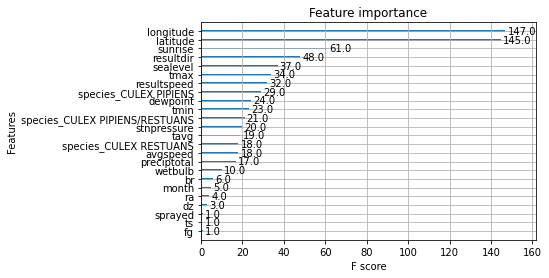

In [ ]:
plot_importance(xbg_model)


In [ ]:
import os
os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

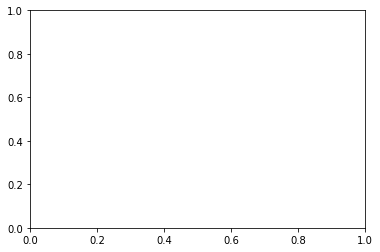

In [ ]:
xgb.plot_tree(model)

In [ ]:
# Scoring the model on training dataset.
# Training Accuracy

train_acc1 = xbg_model.score(X_train, y_train)
train_acc1

0.9524858401510384

In [ ]:
# Estimated Testing Accuracy

est_test_acc1 = cross_val_score(xbg_model, X_train, y_train, cv=5).mean()
est_test_acc1

C:\Users\Admin\.conda\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Admin\.conda\envs\myenv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[09:48:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Admin\.conda\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Admin\.conda\envs\myenv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[09:48:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Admin\.conda\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Admin\.conda\envs\myenv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[09:48:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Admin\.conda\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Admin\.conda\envs\myenv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[09:48:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Admin\.conda\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Admin\.conda\envs\myenv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[09:48:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9403718163779324

In [ ]:
# Actual Testing Accuracy

test_acc1 = xbg_model.score(X_test, y_test)
test_acc1

C:\Users\Admin\.conda\envs\myenv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0.9428975932043416

In [ ]:
# Generating predictions on testing dataset using the model above.

y_pred1 = xbg_model.predict(X_test)

C:\Users\Admin\.conda\envs\myenv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [ ]:
# Generating prediction probabilities on testing dataset using the model above.

y_pred_proba1 = xbg_model.predict_proba(X_test)

In [ ]:
# Generating a confusion matrix.

tn, fp, fn, tp = confusion_matrix(y_test, y_pred1).ravel()

In [ ]:
conf_mat1 = pd.DataFrame(columns=['Actual WnvPresent=1', 'Actual WnvPresent=0'], 
                         index=['Predicted WnvPresent=1', 'Predicted WnvPresent=0'],
                         data=[[f'{tp} (True Pos)', f'{fp} (False Pos)'], [f'{fn} (False Neg)', f'{tn} (True Neg)']]
                        )
conf_mat1

,Actual WnvPresent=1,Actual WnvPresent=0
Predicted WnvPresent=1,5 (True Pos),12 (False Pos)
Predicted WnvPresent=0,109 (False Neg),1993 (True Neg)


In [ ]:
sensitivity1 = tp/(tp+fn)
sensitivity1

0.043859649122807015

In [ ]:
specificity1 = tn/(tn+fp)
specificity1

0.9940149625935162

In [ ]:
precision1 = tp/(tp+fp)
precision1

0.29411764705882354

In [ ]:
roc_auc1 = roc_auc_score(y_test, y_pred_proba1[:, 1])
roc_auc1

0.800721879511747

In [ ]:
summary_df = pd.DataFrame(columns=['Classifier',
                                   'Train Accuracy',
                                   'Est. Test Accuracy (cv=5)',
                                   'Actual Test Accuracy',
                                   'Overfit / Underfit',
                                   'Sensitivity',
                                   'Specificity',
                                   'Precision',
                                   'ROC-AUC',
                                   'Kaggle ROC-AUC'
                                  ])

In [ ]:
summary_df.loc[1] = ["XGBoost",
                     round(train_acc1, 3),
                     round(est_test_acc1, 3),
                     round(test_acc1, 3),
                     round(train_acc1-test_acc1, 3),
                     round(sensitivity1, 3),
                     round(specificity1, 3),
                     round(precision1, 3),
                     round(roc_auc1, 3),
                     0.661
                    ]

summary_df

,Classifier,Train Accuracy,Est. Test Accuracy (cv=5),Actual Test Accuracy,Overfit / Underfit,Sensitivity,Specificity,Precision,ROC-AUC,Kaggle ROC-AUC
1,XGBoost,0.952,0.94,0.943,0.01,0.044,0.994,0.294,0.801,0.661
